1 – Install Dependencies

In [16]:
!pip install pandas numpy scikit-learn matplotlib seaborn joblib pytest

2 – Imports

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


 3 – Preprocessing Function

In [31]:
def preprocess_data(filepath):
    data = pd.read_csv(filepath)

    data['City'] = data['Location'].str.split(',').str[-1].str.strip()
    drop_cols = ['Price', 'Description', 'Property Title', 'Name', 'Balcony', 'Location']
    data.drop(columns=drop_cols, errors='ignore', inplace=True)
    data['BHK'].fillna(data['BHK'].median(), inplace=True)

    # One-hot encode city
    data = pd.get_dummies(data, columns=['City'], prefix='City')
    city_columns = [c for c in data.columns if c.startswith('City_')]

    # Log transforms
    for col in ['Price_INR', 'Price_per_SQFT', 'Total_Area', 'BHK', 'Baths']:
        data[col] = np.log(data[col] + 1)

    # City aggregates
    city_avg_pricepsqft = {col: data.loc[data[col] == 1, 'Price_per_SQFT'].mean() for col in city_columns}
    city_avg_area = {col: data.loc[data[col] == 1, 'Total_Area'].mean() for col in city_columns}

    data['City_Avg_Price_per_SQFT'] = data[city_columns].mul(pd.Series(city_avg_pricepsqft)).sum(axis=1)
    data['City_Avg_Area'] = data[city_columns].mul(pd.Series(city_avg_area)).sum(axis=1)

    # Engineering features
    data['Total_Rooms'] = data['Baths'] + data['BHK']
    data['Area_per_BHK'] = data['Total_Area'] / data['BHK']
    data['Area_per_Room'] = data['Total_Area'] / data['Total_Rooms']
    data['Baths_per_BHK'] = data['Baths'] / data['BHK']
    data['Has_Balcony'] = data['Balcony_num'].astype(int)
    data.drop(columns=['Balcony_num'], inplace=True)

    return data, city_columns, city_avg_pricepsqft, city_avg_area


4 – Train Model

In [40]:

import joblib
import numpy as np

def train_and_save_model(data_path):
    # Preprocess data
    data, city_columns, city_avg_pricepsqft, city_avg_area = preprocess_data(data_path)

    # Define features
    feature_columns = [
        'Total_Area', 'Price_per_SQFT', 'Baths', 'BHK', 'Has_Balcony',
        'City_Avg_Area', 'City_Avg_Price_per_SQFT',
        'Total_Rooms', 'Area_per_BHK', 'Area_per_Room', 'Baths_per_BHK'
    ] + city_columns

    X, y = data[feature_columns], data['Price_INR']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define models to compare
    models = {
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42)
    }

    results = {}

    print("\n📊 Model Performance Comparison:")
    print("-" * 50)
    for name, mdl in models.items():
        mdl.fit(X_train, y_train)
        y_pred = mdl.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(np.exp(y_test) - 1, np.exp(y_pred) - 1)
        mse = mean_squared_error(np.exp(y_test) - 1, np.exp(y_pred) - 1)
        rmse = np.sqrt(mse)

        results[name] = {"R2": r2, "MAE": mae, "RMSE": rmse}
        print(f"{name:17} | R²: {r2:.4f} | MAE: ₹{mae:,.0f} | RMSE: ₹{rmse:,.0f}")

    # Choose only Random Forest to save
    final_model = models["Random Forest"]

    joblib.dump({
        'model': final_model,
        'feature_columns': feature_columns,
        'avg_pricepsqft': city_avg_pricepsqft,
        'avg_area': city_avg_area,
        'city_columns': city_columns
    }, "model_and_stats.pkl")

    print("\n✅ Random Forest model saved to model_and_stats.pkl")
    results_df = pd.DataFrame(results).T
    plot_model_performance_comparison(results)


5. Plot Performance Comparison

In [41]:
def plot_model_performance_comparison(results):
    """
    Plot comparison of R2, MAE, and RMSE for given models.

    Parameters:
    - results: dict of model_name -> dict with keys 'R2', 'MAE', 'RMSE'
    """
    model_names = list(results.keys())
    r2_scores = [results[m]['R2'] for m in model_names]
    mae_scores = [results[m]['MAE'] for m in model_names]
    rmse_scores = [results[m]['RMSE'] for m in model_names]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # R² Score
    axes[0].bar(model_names, r2_scores, color=['skyblue', 'salmon', 'lightgreen'])
    axes[0].set_title('R² Score Comparison')
    axes[0].set_ylim(0, 1)
    axes[0].set_ylabel('R² Score')

    # MAE
    axes[1].bar(model_names, mae_scores, color=['skyblue', 'salmon', 'lightgreen'])
    axes[1].set_title('Mean Absolute Error (MAE) Comparison')
    axes[1].set_ylabel('MAE (INR)')

    # RMSE
    axes[2].bar(model_names, rmse_scores, color=['skyblue', 'salmon', 'lightgreen'])
    axes[2].set_title('Root Mean Squared Error (RMSE) Comparison')
    axes[2].set_ylabel('RMSE (INR)')

    for ax in axes:
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.suptitle('Model Performance Comparison')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


6. Prediction Of House Price

In [42]:
def predict_house_price(price_per_sqft, total_area, bhk, baths, has_balcony, city):
    stats = joblib.load("model_and_stats.pkl")
    model = stats['model']
    feature_columns = stats['feature_columns']
    city_avg_pricepsqft = stats['avg_pricepsqft']
    city_avg_area = stats['avg_area']
    city_list = [c.replace("City_", "") for c in stats['city_columns']]

    avg_area = city_avg_area.get(f'City_{city}', 0)
    avg_price = city_avg_pricepsqft.get(f'City_{city}', 0)

    df = pd.DataFrame([{
        'Total_Area': np.log(total_area + 1),
        'Price_per_SQFT': np.log(price_per_sqft + 1),
        'Baths': np.log(baths + 1),
        'BHK': np.log(bhk + 1),
        'Has_Balcony': has_balcony,
        'City_Avg_Area': avg_area,
        'City_Avg_Price_per_SQFT': avg_price
    }])
    df['Total_Rooms'] = df['Baths'] + df['BHK']
    df['Area_per_BHK'] = df['Total_Area'] / df['BHK']
    df['Area_per_Room'] = df['Total_Area'] / df['Total_Rooms']
    df['Baths_per_BHK'] = df['Baths'] / df['BHK']

    for c in city_list:
        df[f'City_{c}'] = int(c.lower() == city.lower())

    df = df[feature_columns]
    log_price = model.predict(df)[0]
    return np.exp(log_price) - 1


6 – Example Training Run

/tmp/ipython-input-308129269.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['BHK'].fillna(data['BHK'].median(), inplace=True)



📊 Model Performance Comparison:
--------------------------------------------------
Decision Tree     | R²: 0.9164 | MAE: ₹1,136,643 | RMSE: ₹11,281,525
Random Forest     | R²: 0.9238 | MAE: ₹674,933 | RMSE: ₹9,376,345
Gradient Boosting | R²: 0.9044 | MAE: ₹1,072,645 | RMSE: ₹9,653,551

✅ Random Forest model saved to model_and_stats.pkl


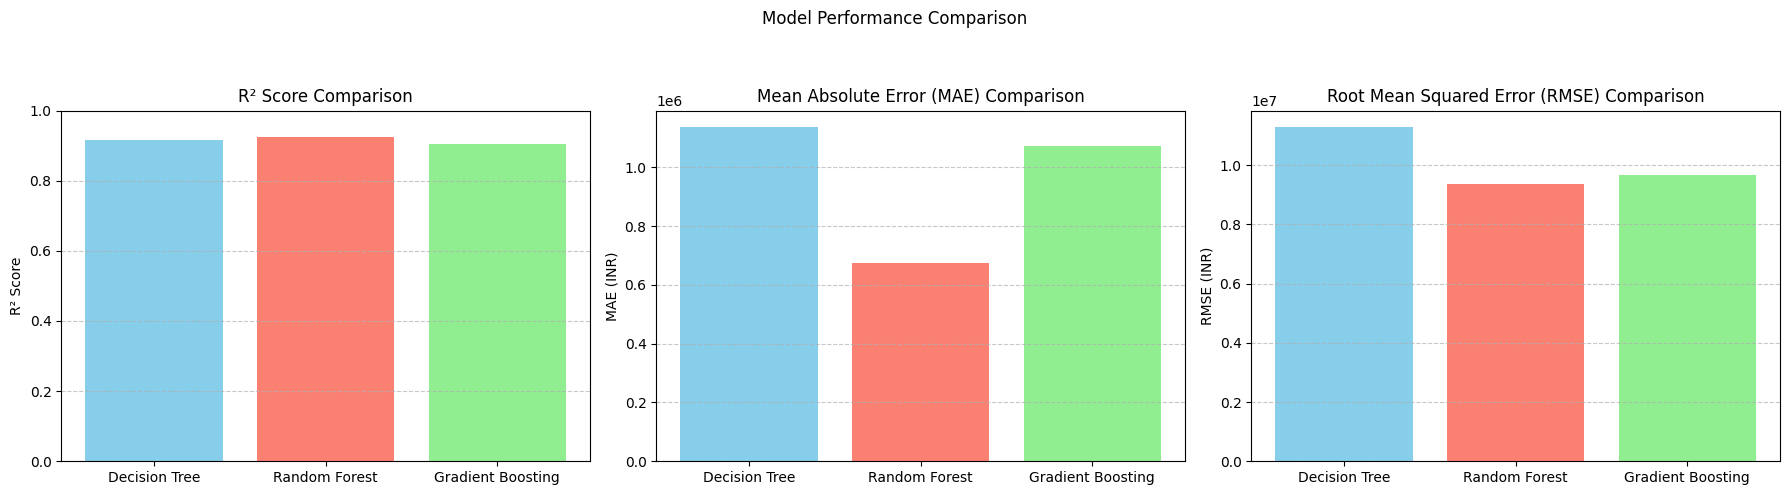

In [43]:
train_and_save_model("merged_housing_data.csv")


7 – Example Prediction

In [20]:
price = predict_house_price(8500, 1250, 4, 4, 1, "Bangalore")
print(f"💰 Predicted Price: ₹{price:,.0f}")


💰 Predicted Price: ₹10,707,753


8 – Feature Importance Plot

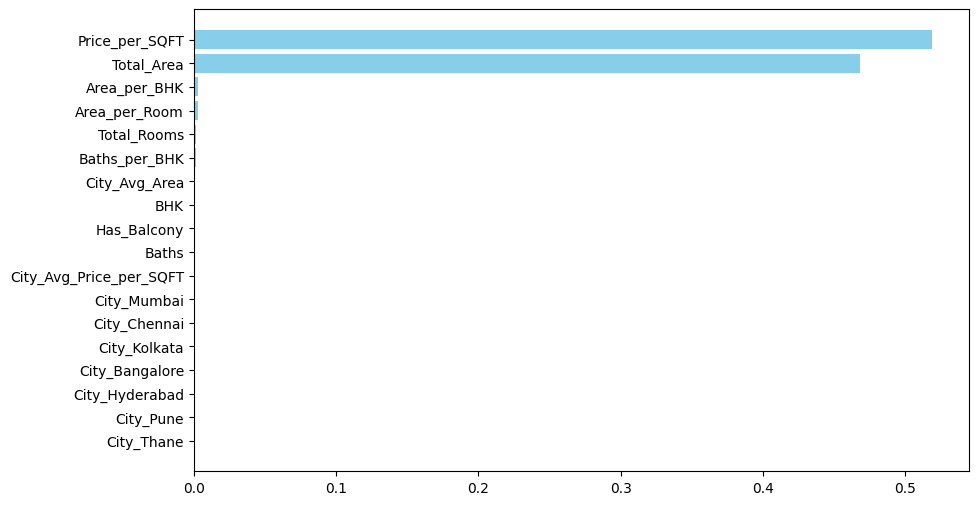

In [21]:
def plot_feature_importance():
    stats = joblib.load("model_and_stats.pkl")
    model = stats['model']
    feature_columns = stats['feature_columns']
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feature_columns)), importances[indices][::-1], color='skyblue')
    plt.yticks(range(len(feature_columns)), [feature_columns[i] for i in indices][::-1])
    plt.show()

plot_feature_importance()
